# Google Trend Spike Detection



## 0. Setup

In [1]:
import os
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, average_precision_score, precision_recall_curve, f1_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (10,5)




In [3]:
csv_path = "/content/drive/MyDrive/bigq.csv"
df = pd.read_csv(csv_path)

df["term"] = df["term"].astype(str).str.strip().str.lower()
df["week"] = pd.to_datetime(df["week"], errors="coerce")
df["weekly_score"] = pd.to_numeric(df["weekly_score"], errors="coerce")

# Drop rows missing critical keys
df = df.dropna(subset=["term","week"])

# Repair weekly_score per term (fix gaps), then recompute a SAFE normalization
def repair_scores(g):
    s = g["weekly_score"].ffill().bfill()   # fill gaps inside term
    return g.assign(weekly_score=s)

df = df.sort_values(["term","week"]).groupby("term", group_keys=False).apply(repair_scores)

def safe_minmax(s):
    # 0..100 per-term; if constant series, return zeros instead of NaN
    s_min, s_max = s.min(), s.max()
    rng = s_max - s_min
    if not np.isfinite(rng) or rng < 1e-9:
        return pd.Series(np.zeros(len(s), dtype=float), index=s.index)
    return 100.0 * (s - s_min) / (rng + 1e-9)

df["weekly_score_norm"] = df.groupby("term")["weekly_score"].transform(safe_minmax)

# no NaNs now
assert df["weekly_score_norm"].notna().all(), "weekly_score_norm still has NaNs; check input weekly_score."

# Create features (lags + seasonality + motion)
MAX_LAG = 12
for k in range(1, MAX_LAG+1):
    df[f"lag_{k}"] = df.groupby("term")["weekly_score_norm"].shift(k)

df["month"]   = df["week"].dt.month
df["year"]    = df["week"].dt.year
woy = df["week"].dt.isocalendar().week.astype(int)
df["sin_woy"] = np.sin(2*np.pi*woy/52.0)
df["cos_woy"] = np.cos(2*np.pi*woy/52.0)

def add_motion(g, col="weekly_score_norm"):
    g = g.sort_values("week").copy()
    g["diff_1"] = g[col].diff(1)
    g["diff_4"] = g[col].diff(4)
    g["pct_1"]  = g[col].pct_change(1).replace([np.inf, -np.inf], 0.0)
    g["roll_mean_4"] = g[col].rolling(4).mean()
    g["roll_mean_8"] = g[col].rolling(8).mean()
    g["roll_std_8"]  = g[col].rolling(8).std()
    return g

df = df.groupby("term", group_keys=False).apply(add_motion)



In [4]:
# Drop structural NaNs from lags/rolls (first weeks per term)
lag_cols   = [c for c in df.columns if c.startswith("lag_")]
motion_req = [c for c in ["roll_mean_4","roll_mean_8","roll_std_8"] if c in df.columns]
drop_subset = lag_cols + motion_req
df = df.dropna(subset=drop_subset).reset_index(drop=True)

# Term-level stats (compact identity signals)
df["term_mean"] = df.groupby("term")["weekly_score_norm"].transform("mean")
df["term_std"]  = df.groupby("term")["weekly_score_norm"].transform("std").fillna(0.0)

# Per-term splits: last 12 = test, previous 12 = valid
VALID_W, TEST_W = 12, 12
df["split"] = "train"
for t, g in df.groupby("term"):
    idx = g.index
    n = len(idx)
    if n >= TEST_W:
        df.loc[idx[-TEST_W:], "split"] = "test"
    if n >= TEST_W + VALID_W:
        df.loc[idx[-(TEST_W+VALID_W):-TEST_W], "split"] = "valid"

# Build LightGBM feature list from what exists
seasonal   = [c for c in ["month","year","sin_woy","cos_woy"] if c in df.columns]
motion     = [c for c in ["diff_1","diff_4","pct_1","roll_mean_4","roll_mean_8","roll_std_8"] if c in df.columns]
term_stats = [c for c in ["term_mean","term_std"] if c in df.columns]
features_lgb = lag_cols + seasonal + term_stats + motion
target_col = "weekly_score_norm"

# Clean splits (drop any rows with NaNs in selected features/target)
df_clean = df.dropna(subset=features_lgb + [target_col]).copy()
train = df_clean[df_clean["split"]=="train"]
valid = df_clean[df_clean["split"]=="valid"]
test  = df_clean[df_clean["split"]=="test"]

X_train, y_train = train[features_lgb], train[target_col]
X_valid, y_valid = valid[features_lgb], valid[target_col]
X_test,  y_test  = test[features_lgb],  test[target_col]

# Fill any residual feature NaNs with per-column medians from train
med = X_train.median(numeric_only=True)
X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(med)
X_valid = X_valid.apply(pd.to_numeric, errors="coerce").fillna(med)
X_test  = X_test.apply(pd.to_numeric,  errors="coerce").fillna(med)

print(f"Shapes : Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")
print("Features used:", features_lgb[:10], "total:", len(features_lgb))


Shapes : Train: (5791, 24), Valid: (309, 24), Test: (306, 24)
Features used: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10'] total: 24


In [5]:
model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=4000,
    learning_rate=0.02,
    num_leaves=127,
    min_data_in_leaf=10,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    verbose=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(100)]
)

pred_val  = model.predict(X_valid, num_iteration=model.best_iteration_)
pred_test = model.predict(X_test,  num_iteration=model.best_iteration_)

rmse_val  = np.sqrt(mean_squared_error(y_valid, pred_val))
rmse_test = np.sqrt(mean_squared_error(y_test,  pred_test))
r2_val    = r2_score(y_valid, pred_val)
r2_test   = r2_score(y_test,  pred_test)

print(f"VALID: RMSE={rmse_val:.2f}, R²={r2_val:.3f}")
print(f"TEST : RMSE={rmse_test:.2f}, R²={r2_test:.3f}")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.04302	valid_0's l2: 9.25996
[200]	valid_0's rmse: 1.72622	valid_0's l2: 2.97983
[300]	valid_0's rmse: 1.54967	valid_0's l2: 2.40146
[400]	valid_0's rmse: 1.53238	valid_0's l2: 2.34819
[500]	valid_0's rmse: 1.54326	valid_0's l2: 2.38167
Early stopping, best iteration is:
[373]	valid_0's rmse: 1.52859	valid_0's l2: 2.3366
VALID: RMSE=1.53, R²=0.987
TEST : RMSE=2.07, R²=0.994


In [6]:
eval_df = test[["term","week"]].copy()
eval_df["y"] = y_test.values
eval_df["yhat"] = pred_test

per_term_rmse = eval_df.groupby("term").apply(
    lambda g: np.sqrt(mean_squared_error(g["y"], g["yhat"]))
).sort_values()

print("Per-term RMSE (best to worst):")
print(per_term_rmse)


Per-term RMSE (best to worst):
term
netflix stock                             0.102405
is hulu down                              0.104868
premier league                            0.417539
mlb draft time                            0.756099
barcelona - como                          0.757374
disney plus cancelled shows               0.789646
netflix pride and prejudice cast          0.794021
premier league summer series              0.813012
hulu                                      0.840341
netflix teaser trailer stranger things    0.857325
fc seoul vs barcelona                     1.450331
barcelona vs como                         1.450446
vissel kobe - barcelona                   1.450533
psg - tottenham                           1.451270
chelsea - psg                             1.513280
harry potter hbo series                   1.528787
mlb trade deadline                        1.544973
ufc paramount                             1.725878
untamed netflix                           1.75

In [7]:
fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print("Top features:")
print(fi.head(20))


Top features:
        feature  importance
0         lag_1        8912
18       diff_1        6524
20        pct_1        4996
3         lag_4        3235
19       diff_4        2991
21  roll_mean_4        2789
1         lag_2        2480
2         lag_3        2416
23   roll_std_8        1603
10       lag_11         990
7         lag_8         962
8         lag_9         957
5         lag_6         934
4         lag_5         930
9        lag_10         927
11       lag_12         926
6         lag_7         922
22  roll_mean_8         783
15      cos_woy         754
14      sin_woy         682


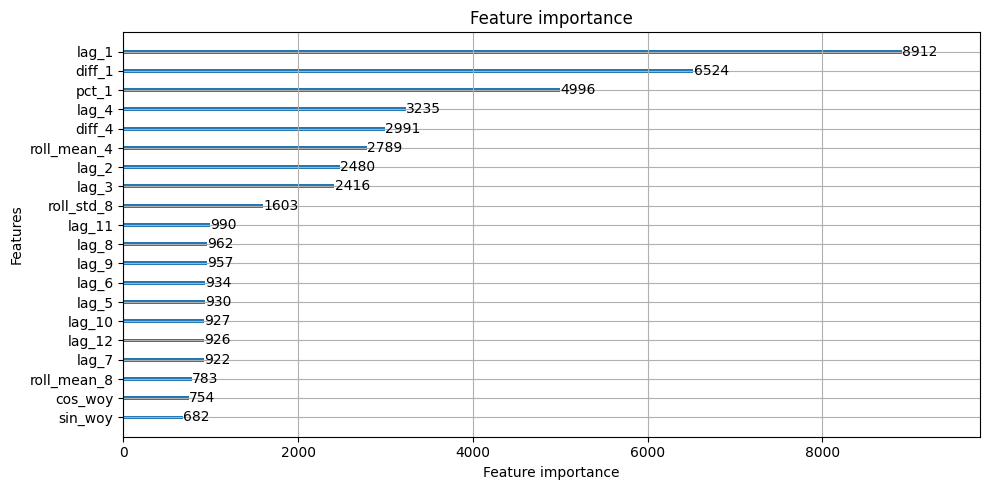

In [8]:
lgb.plot_importance(model, max_num_features=20)
plt.tight_layout(); plt.show()


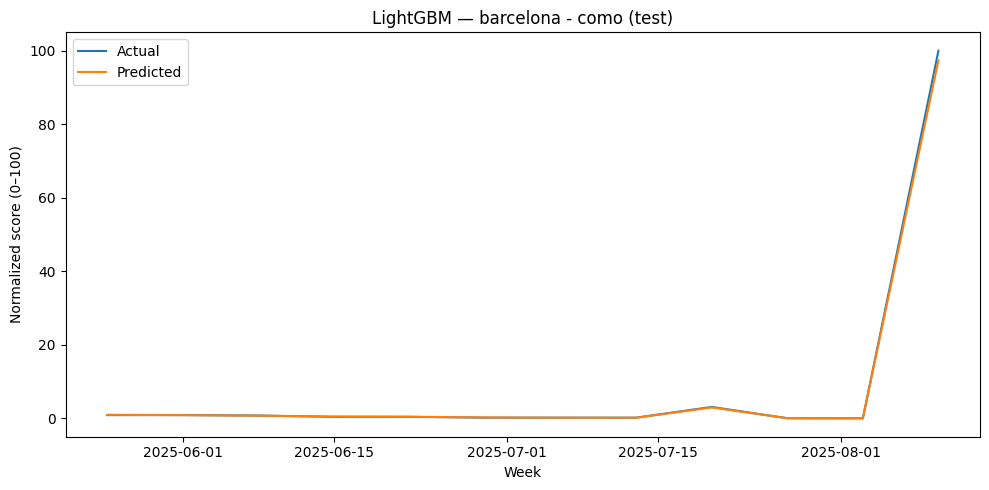

In [9]:
term_to_plot = eval_df["term"].iloc[0]   # or pick a specific term
g = eval_df[eval_df["term"]==term_to_plot].sort_values("week")

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(g["week"], g["y"],    label="Actual")
plt.plot(g["week"], g["yhat"], label="Predicted")
plt.title(f"LightGBM — {term_to_plot} (test)")
plt.xlabel("Week"); plt.ylabel("Normalized score (0–100)")
plt.legend(); plt.tight_layout(); plt.show()


In [10]:
# Spike
eval_df["resid"] = (eval_df["y"] - eval_df["yhat"]).abs()
thr = eval_df["resid"].mean() + 2*eval_df["resid"].std()
eval_df["is_spike"] = (eval_df["resid"] > thr).astype(int)

stable = eval_df[eval_df["is_spike"]==0]
spikes = eval_df[eval_df["is_spike"]==1]

from sklearn.metrics import mean_squared_error
rmse_stable = np.sqrt(mean_squared_error(stable["y"], stable["yhat"])) if len(stable) else np.nan
rmse_spikes = np.sqrt(mean_squared_error(spikes["y"], spikes["yhat"])) if len(spikes) else np.nan

print(f"Spike threshold: {thr:.2f}")
print(f"Stable weeks RMSE: {rmse_stable:.2f} (n={len(stable)})")
print(f"Spike weeks  RMSE: {rmse_spikes:.2f} (n={len(spikes)})")


Spike threshold: 4.61
Stable weeks RMSE: 0.73 (n=286)
Spike weeks  RMSE: 7.62 (n=20)


In [11]:
# Predict with LightGBM
pred_train = model.predict(X_train, num_iteration=getattr(model, "best_iteration_", None))
pred_valid = model.predict(X_valid, num_iteration=getattr(model, "best_iteration_", None))
pred_test  = model.predict(X_test,  num_iteration=getattr(model, "best_iteration_", None))


In [12]:
# Attach term/week IDs to predictions
preds_train = train[["term", "week"]].copy()
preds_train["y"] = y_train.values
preds_train["yhat_base"] = pred_train
preds_train["split"] = "train"

preds_valid = valid[["term", "week"]].copy()
preds_valid["y"] = y_valid.values
preds_valid["yhat_base"] = pred_val
preds_valid["split"] = "valid"

preds_test = test[["term", "week"]].copy()
preds_test["y"] = y_test.values
preds_test["yhat_base"] = pred_test
preds_test["split"] = "test"


In [13]:
# Ensure preds_* exist
assert {"term","week","y","yhat_base"}.issubset(set(preds_train.columns))
assert {"term","week","y","yhat_base"}.issubset(set(preds_valid.columns))
assert {"term","week","y","yhat_base"}.issubset(set(preds_test.columns))

eval_all = pd.concat([
    preds_train.assign(split="train"),
    preds_valid.assign(split="valid"),
    preds_test.assign(split="test")
], ignore_index=True).sort_values(["term","week"])

eval_all["resid_abs"] = (eval_all["y"] - eval_all["yhat_base"]).abs()

def robust_thr(s: pd.Series):
    s = s.dropna()
    if s.empty: return np.inf
    med = s.median()
    mad = (s - med).abs().median() + 1e-9
    return med + 3.5 * 1.4826 * mad   # robust threshold

thr_map = (eval_all[eval_all["split"]=="train"]
           .groupby("term")["resid_abs"].apply(robust_thr))
eval_all = eval_all.join(thr_map.rename("thr_term"), on="term")
eval_all["is_spike_label"] = (eval_all["resid_abs"] > eval_all["thr_term"]).astype(int)

# Attach labels back to preds_*
preds_train = preds_train.merge(eval_all[["term","week","is_spike_label"]], on=["term","week"], how="left")
preds_valid = preds_valid.merge(eval_all[["term","week","is_spike_label"]], on=["term","week"], how="left")
preds_test  = preds_test .merge(eval_all[["term","week","is_spike_label"]], on=["term","week"], how="left")

# Build classifier mats from your existing tabular features (features_lgb)
def mats_cls(ids_df):
    part = ids_df[["term","week","is_spike_label"]].merge(
        df[["term","week"] + features_lgb], on=["term","week"], how="left"
    )
    X = part[features_lgb].apply(pd.to_numeric, errors="coerce")
    # fill with TRAIN medians from your regression mats
    med = X_train.median(numeric_only=True)
    X = X.fillna(med)
    y = part["is_spike_label"].astype(int).values
    return X, y

X_trc, y_trc = mats_cls(preds_train)
X_vac, y_vac = mats_cls(preds_valid)
X_tec, y_tec = mats_cls(preds_test)

# Train spike classifier (LightGBM)
clf = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=63,
    min_data_in_leaf=10,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
clf.fit(
    X_trc, y_trc,
    eval_set=[(X_vac, y_vac)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(100)]
)

# Probabilities for TEST
p_spike_test = clf.predict_proba(X_tec)[:, 1]
print("Spike classifier:",
      "AUC =", round(roc_auc_score(y_tec, p_spike_test), 3) if len(np.unique(y_tec))>1 else "n/a",
      "| AP =",  round(average_precision_score(y_tec, p_spike_test), 3) if len(np.unique(y_tec))>1 else "n/a")



Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.785545	valid_0's binary_logloss: 1.09182
[200]	valid_0's auc: 0.785498	valid_0's binary_logloss: 1.36344
Early stopping, best iteration is:
[13]	valid_0's auc: 0.763403	valid_0's binary_logloss: 0.930133
Spike classifier: AUC = 0.864 | AP = 0.814


In [14]:

# Ensure we have an upper envelope to cap extreme blended values
if "roll_max_8" not in df.columns:
    df = df.sort_values(["term","week"]).copy()
    df["roll_max_8"] = (
        df.groupby("term")["weekly_score_norm"]
          .rolling(8, min_periods=1).max()
          .reset_index(level=0, drop=True)
    )

test_with_env = preds_test.merge(df[["term","week","roll_max_8"]],
                                 on=["term","week"], how="left")
upper_cap = np.maximum(test_with_env["roll_max_8"].values,
                       preds_test["yhat_base"].values)

# Choose blending settings
p_thr = 0.50       # spike prob threshold; try 0.4–0.6
alpha_when_spike = 0.60  # blend weight when spike likely; try 0.4–0.7

# If you trained an uplift model, use it; otherwise fallback to recent-max uplift
have_uplift = "uplift_pred" in globals() or "uplift_pred" in locals()

if have_uplift:
    raw_uplift = uplift_pred  # should be same order as preds_test
else:
    # Fallback uplift: push toward recent envelope (conservative)
    raw_uplift = (upper_cap - preds_test["yhat_base"].values)

# Blend only when spike probability is high
alpha = (p_spike_test > p_thr).astype(float) * alpha_when_spike
yhat_blend = preds_test["yhat_base"].values + alpha * raw_uplift

# Safety cap
yhat_blend = np.minimum(yhat_blend, upper_cap)

# Attach back to preds_test
preds_test = preds_test.copy()
preds_test["yhat_blend"] = yhat_blend


In [15]:
p_thr = 0.50
alpha_when_spike = 0.60
alpha = (p_spike_test > p_thr).astype(float) * alpha_when_spike
uplift_simple = upper_cap - preds_test["yhat_base"].values
yhat_blend = np.minimum(preds_test["yhat_base"].values + alpha * uplift_simple, upper_cap)
preds_test["yhat_blend"] = yhat_blend


In [16]:
def eval_blend(p_thr, alpha_w, base, upper_cap, p_spike, y_true, y_tec_mask):
    # --- Align all inputs to the same length ---
    n = min(len(base), len(upper_cap), len(p_spike), len(y_true), len(y_tec_mask))
    base        = base[:n]
    upper_cap   = upper_cap[:n]
    p_spike     = p_spike[:n]
    y_true      = y_true[:n]
    y_tec_mask  = y_tec_mask[:n]

    # --- Compute blended prediction ---
    alpha = (p_spike > p_thr).astype(float) * alpha_w
    yhat  = np.minimum(base + alpha * (upper_cap - base), upper_cap)

    # --- Compute RMSEs ---
    rmse_all   = mean_squared_error(y_true, yhat)
    rmse_stab  = mean_squared_error(y_true[y_tec_mask == 0],
                                    yhat[y_tec_mask == 0]) if (y_tec_mask == 0).any() else np.nan
    rmse_spike = mean_squared_error(y_true[y_tec_mask == 1],
                                    yhat[y_tec_mask == 1]) if (y_tec_mask == 1).any() else np.nan
    return rmse_all, rmse_stab, rmse_spike

# --- Your data ---
base = preds_test["yhat_base"].values
y    = preds_test["y"].values
p    = p_spike_test  # predicted spike probability for test set
# y_tec is your spike/stable mask for the test set

# --- Grid search ---
grid_p   = [0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
grid_a   = [0.3, 0.4, 0.5, 0.6, 0.7]
best = None

for pt, aw in product(grid_p, grid_a):
    rmse_all, rmse_st, rmse_sp = eval_blend(pt, aw, base, upper_cap, p, y, y_tec)
    if best is None or rmse_sp < best["rmse_sp"]:
        best = {"p_thr": pt, "alpha": aw, "rmse_all": rmse_all, "rmse_st": rmse_st, "rmse_sp": rmse_sp}

print("Best blend:",
      f"p_thr={best['p_thr']}, alpha={best['alpha']}",
      f"| RMSE all={best['rmse_all']:.2f}, stable={best['rmse_st']:.2f}, spike={best['rmse_sp']:.2f}")


Best blend: p_thr=0.35, alpha=0.7 | RMSE all=3.73, stable=0.01, spike=10.18


                                        rmse_base  rmse_blend     n
term                                                               
netflix stock                            0.010487    0.010487  12.0
is hulu down                             0.010997    0.010997  12.0
mlb draft time                           0.571686    0.053046  12.0
barcelona - como                         0.573615    0.054975  12.0
disney plus cancelled shows              0.623542    0.071416  12.0
netflix pride and prejudice cast         0.630470    0.078344  12.0
netflix teaser trailer stranger things   0.735006    0.132688  11.0
premier league summer series             0.660988    0.166868  12.0
premier league                           0.174339    0.174339  12.0
fc seoul vs barcelona                    2.103460    0.189425  12.0
                                     rmse_base  rmse_blend     n
term                                                            
harry potter hbo series               2.337190    2.33

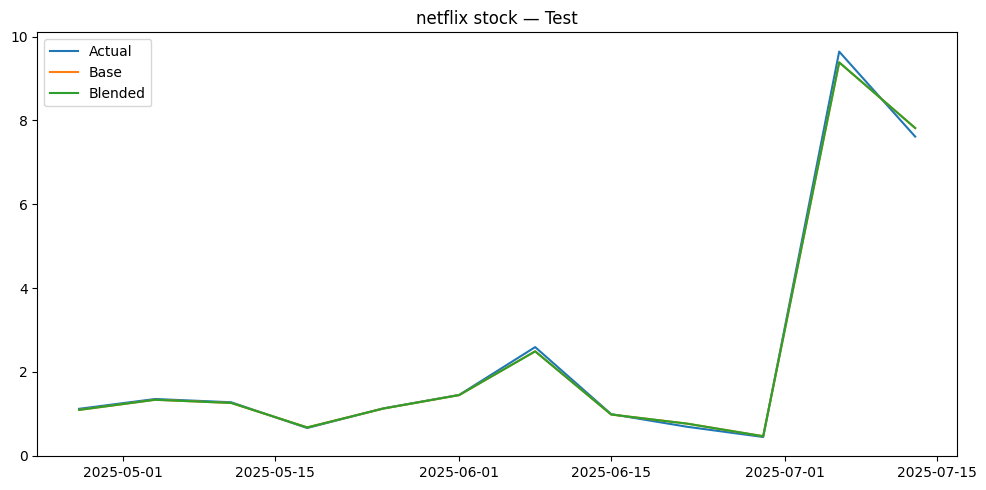

In [17]:
preds_test["yhat_blend"] = np.minimum(
    base + ((p > best["p_thr"]).astype(float) * best["alpha"]) * (upper_cap - base),
    upper_cap
)

per_term = preds_test.groupby("term").apply(
    lambda g: pd.Series({
        "rmse_base":  mean_squared_error(g["y"], g["yhat_base"]),
        "rmse_blend": mean_squared_error(g["y"], g["yhat_blend"]),
        "n": len(g)
    })
).sort_values("rmse_blend")
print(per_term.head(10))
print(per_term.tail(10))

# Plot one improved term
term_to_plot = per_term.index[0]
g = preds_test[preds_test["term"]==term_to_plot].sort_values("week")
plt.figure(figsize=(10,5))
plt.plot(g["week"], g["y"], label="Actual")
plt.plot(g["week"], g["yhat_base"], label="Base")
plt.plot(g["week"], g["yhat_blend"], label="Blended")
plt.title(f"{term_to_plot} — Test")
plt.legend(); plt.tight_layout(); plt.show()


In [18]:
preds_test["resid"] = (preds_test["y"] - preds_test["yhat_base"]).abs()
thr = preds_test["resid"].mean() + 2 * preds_test["resid"].std()
preds_test["p_spike"] = (preds_test["resid"] > thr).astype(float)  # 1.0 or 0.0


In [19]:
SEQ_LEN = 12
TARGET = "weekly_score_norm"
EXO_CANDS = ["sin_woy","cos_woy","diff_1","roll_std_8","roll_max_8"]  # use what you have
EXO = [c for c in EXO_CANDS if c in df.columns]  # auto-detect

def make_sequences(df, seq_len=SEQ_LEN, target=TARGET, exos=EXO):
    rows = []
    for term, g in df.sort_values(["term","week"]).groupby("term"):
        g = g.sort_values("week").copy()
        y = g[target].astype(float).values
        mu, sigma = np.nanmean(y), np.nanstd(y) + 1e-6
        y_std = (y - mu) / sigma

        if exos:
            E = g[exos].astype(float).values
            Emu = np.nanmean(E, axis=0); Esd = np.nanstd(E, axis=0) + 1e-6
            E_std = (E - Emu) / Esd
            def feats(i,j): return np.c_[y_std[i:j], E_std[i:j]]
        else:
            def feats(i,j): return y_std[i:j][:,None]

        for i in range(len(g) - seq_len):
            j = i + seq_len
            rows.append({
                "term": term,
                "week": g["week"].iloc[j],
                "split": g["split"].iloc[j],
                "X": feats(i,j).astype("float32"),
                "y_std": np.float32(y_std[j]),
                "y": np.float32(y[j]),
                "mu": mu, "sigma": sigma
            })
    seq = pd.DataFrame(rows)
    def mats(part):
        X = np.stack(part["X"].values)
        y_std = part["y_std"].values
        y = part["y"].values
        info = part[["term","week","mu","sigma"]].reset_index(drop=True)
        return X, y_std, y, info
    Xtr, ytr_s, ytr, info_tr = mats(seq[seq["split"]=="train"])
    Xva, yva_s, yva, info_va = mats(seq[seq["split"]=="valid"])
    Xte, yte_s, yte, info_te = mats(seq[seq["split"]=="test"])
    return (Xtr,ytr_s,ytr,info_tr), (Xva,yva_s,yva,info_va), (Xte,yte_s,yte,info_te)

(Xtr,ytr_s,ytr,info_tr),(Xva,yva_s,yva,info_va),(Xte,yte_s,yte,info_te) = make_sequences(df)
print("Shapes:", Xtr.shape, Xva.shape, Xte.shape, "  channels:", Xtr.shape[2])


Shapes: (5492, 12, 6) (312, 12, 6) (312, 12, 6)   channels: 6


In [20]:
# Detect spikes from actual values in your sequence sets
def detect_spike_labels(y_true, mu, sigma, std_preds=None, thr_std=None):
    """
    y_true : array of original target values (not std)
    mu, sigma : per-sample scaling factors from make_sequences
    std_preds : optional predicted standardized y (not used here for training labels)
    thr_std : optional fixed threshold in original units; if None, compute from data
    """
    resid = np.abs(y_true - mu)  # placeholder if no predictions yet; you can adapt
    # Here, since we don't have preds yet, we can just use "y_true" deviation from mean
    # Better: run a simple baseline model on train, compute residuals, then threshold.
    if thr_std is None:
        thr = resid.mean() + 2 * resid.std()
    else:
        thr = thr_std
    return (resid > thr).astype(np.float32), thr

# Example: Use baseline mean as prediction to get crude residuals
def spike_labels_from_baseline(y, mu):
    resid = np.abs(y - mu)
    thr = resid.mean() + 2 * resid.std()
    return (resid > thr).astype(np.float32), thr

# Train
ytr_spk, thr_train = spike_labels_from_baseline(ytr, info_tr["mu"].values)
yva_spk, _         = spike_labels_from_baseline(yva, info_va["mu"].values)
yte_spk, _         = spike_labels_from_baseline(yte, info_te["mu"].values)

print(f"Spike threshold (train): {thr_train:.2f}")
print(f"Spike ratio: train={ytr_spk.mean():.3f}, valid={yva_spk.mean():.3f}, test={yte_spk.mean():.3f}")


Spike threshold (train): 18.94
Spike ratio: train=0.048, valid=0.038, test=0.067
